In [12]:
"""
XGBoost Exhaustive Feature Selection
Complete implementation with all methods
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from itertools import combinations
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

# =============================================================================
# DATA LOADING AND SPLITTING
# =============================================================================

df = pd.read_csv('men_2026_matchups_training.csv')

metadata_cols = ['Unnamed: 0', 'game_id', 'year', 'region', 'round',
                 'high_bracket_team', 'low_bracket_team',
                 'high_bracket_seed', 'low_bracket_seed', 'seed']
target_col = 'win'
feature_cols = [col for col in df.columns if col not in metadata_cols + [target_col]]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col])

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[target_col]
X_test = test_df[feature_cols].fillna(0)
y_test = test_df[target_col]

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Total features: {len(feature_cols)}")

Train: (1003, 108)
Test: (251, 108)
Total features: 108


In [13]:
# =============================================================================
# 1. BASELINE XGBOOST MODEL
# =============================================================================

def baseline_xgboost(params=None):
    """Fit baseline XGBoost with all features"""
    if params is None:
        params = {
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'random_state': 42,
            'eval_metric': 'logloss'
        }

    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    model.fit(X_train, y_train)

    print(f"\nBaseline XGBoost:")
    print(f"  Train Accuracy: {model.score(X_train, y_train):.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy: {model.score(X_test, y_test):.4f}")

    return model

baseline_model = baseline_xgboost()


Baseline XGBoost:
  Train Accuracy: 1.0000
  CV Accuracy: 0.7128 (+/- 0.0489)
  Test Accuracy: 0.6972


In [14]:
# =============================================================================
# 2. FEATURE IMPORTANCE (MULTIPLE TYPES)
# =============================================================================

def get_feature_importance(model, importance_type='builtin'):
    """
    Get XGBoost feature importance
    Types: 'builtin', 'gain', 'weight', 'cover'
    """
    if importance_type == 'builtin':
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type=importance_type)

        # get_score() returns actual feature names, not f0, f1, f2
        importance_list = []
        for fname in feature_cols:
            importance_list.append({
                'feature': fname,
                'importance': importance_dict.get(fname, 0.0)
            })

        importance_df = pd.DataFrame(importance_list).sort_values('importance', ascending=False)

    return importance_df

# Get all importance types
model = xgb.XGBClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

builtin_imp = get_feature_importance(model, 'builtin')
gain_imp = get_feature_importance(model, 'gain')
weight_imp = get_feature_importance(model, 'weight')
cover_imp = get_feature_importance(model, 'cover')

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)
print("\nTop 20 by builtin (feature_importances_):")
print(builtin_imp.head(20))
print("\nTop 20 by gain:")
print(gain_imp.head(20))
print("\nTop 20 by weight:")
print(weight_imp.head(20))
print("\nTop 20 by cover:")
print(cover_imp.head(20))


FEATURE IMPORTANCE

Top 20 by builtin (feature_importances_):
                            feature  importance
4                        torvik_rtg    0.130915
0                          5man_bpm    0.068776
3                        kenpom_rtg    0.062529
42                        5man_dbpm    0.024545
70       top5_scoring_concentration    0.018100
1                          3man_bpm    0.017995
2                               wab    0.016629
81                 block_efficiency    0.014868
37                          blk_pct    0.013039
40                  off_far2_fg_pct    0.012357
43                        3man_dbpm    0.012276
100     defensive_versatility_score    0.011860
82   experience_weighted_production    0.011478
16                             3prd    0.011330
44                       kenpom_def    0.011173
71    top5_rebounding_concentration    0.010503
9                              size    0.010416
12                            bench    0.010337
19                   off_

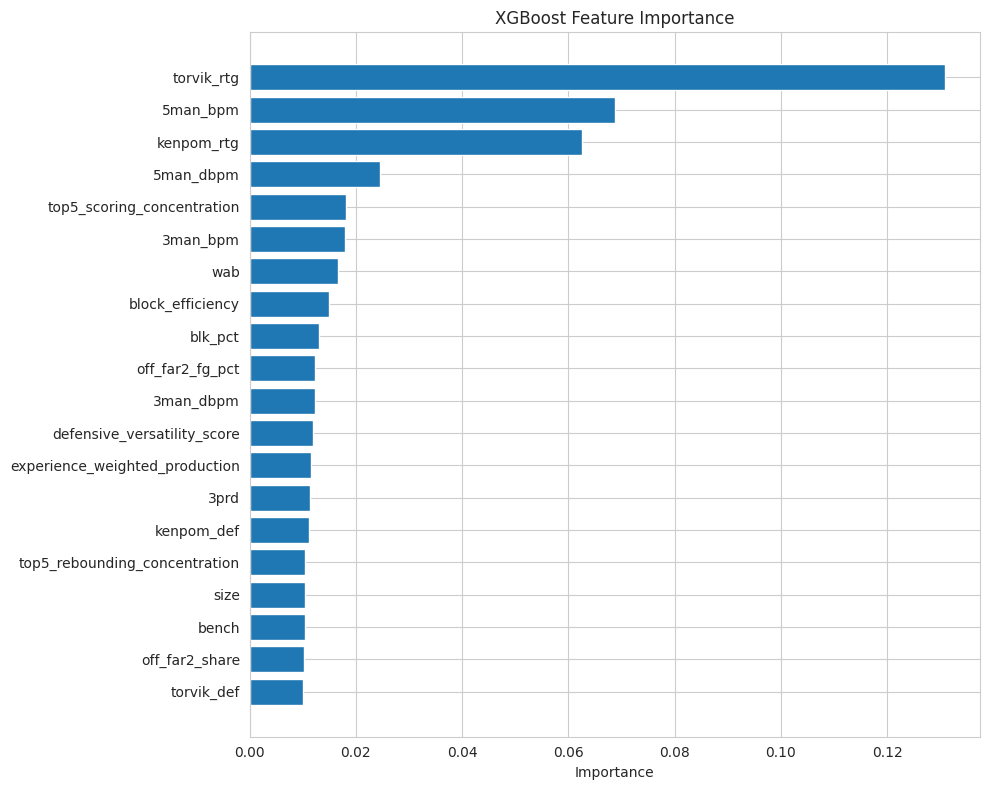

In [15]:
def plot_importance(importance_df, top_n=20, title="Feature Importance"):
    """Plot feature importance"""
    top = importance_df.head(top_n)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top)), top['importance'])
    plt.yticks(range(len(top)), top['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_importance(builtin_imp, top_n=20, title="XGBoost Feature Importance")

In [16]:
# =============================================================================
# 3. PERMUTATION IMPORTANCE
# =============================================================================

def get_permutation_importance(model, n_repeats=10):
    """Calculate permutation importance"""
    perm = permutation_importance(model, X_train, y_train,
                                   n_repeats=n_repeats, random_state=42, n_jobs=-1)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': perm.importances_mean,
        'std': perm.importances_std
    }).sort_values('importance', ascending=False)

    return importance_df

perm_imp = get_permutation_importance(model)
print("\n" + "="*80)
print("PERMUTATION IMPORTANCE")
print("="*80)
print("\nTop 20 by Permutation Importance:")
print(perm_imp.head(20))


PERMUTATION IMPORTANCE

Top 20 by Permutation Importance:
           feature  importance       std
12           bench    0.003589  0.000914
43       3man_dbpm    0.000798  0.000746
36         ast_pct    0.000598  0.000488
0         5man_bpm    0.000000  0.000000
4       torvik_rtg    0.000000  0.000000
5        5man_prpg    0.000000  0.000000
6        3man_prpg    0.000000  0.000000
7       5man_dprpg    0.000000  0.000000
8       3man_dprpg    0.000000  0.000000
1         3man_bpm    0.000000  0.000000
2              wab    0.000000  0.000000
3       kenpom_rtg    0.000000  0.000000
11      experience    0.000000  0.000000
10          height    0.000000  0.000000
9             size    0.000000  0.000000
13       raw_tempo    0.000000  0.000000
16            3prd    0.000000  0.000000
17  off_dunk_share    0.000000  0.000000
14       adj_tempo    0.000000  0.000000
15             3pr    0.000000  0.000000


In [17]:
# =============================================================================
# 4. FORWARD FEATURE SELECTION
# =============================================================================

def forward_selection(max_features=20, cv_folds=5):
    """Forward feature selection - greedy search"""
    selected = []
    remaining = feature_cols.copy()
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    best_score = 0

    print("\n" + "="*80)
    print("FORWARD SELECTION")
    print("="*80)

    for i in range(max_features):
        best_feature = None
        best_cv = best_score
        best_train = 0

        for feature in remaining:
            features = selected + [feature]
            model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
            scores = cross_val_score(model, X_train[features], y_train, cv=cv, scoring='accuracy')

            if scores.mean() > best_cv:
                best_cv = scores.mean()
                best_feature = feature
                model.fit(X_train[features], y_train)
                best_train = model.score(X_train[features], y_train)

        if best_feature is None:
            print(f"Stopped at {len(selected)} features (no improvement)")
            break

        selected.append(best_feature)
        remaining.remove(best_feature)
        best_score = best_cv

        print(f"  {len(selected):2d}. {best_feature:40s} Train: {best_train:.4f} | CV: {best_cv:.4f}")

    return selected

forward_features = forward_selection(max_features=20)


FORWARD SELECTION
   1. torvik_rtg                               Train: 0.7817 | CV: 0.7088
   2. bench                                    Train: 0.9561 | CV: 0.7218
   3. def_mid_range_reliance                   Train: 0.9980 | CV: 0.7337
   4. 3man_prpg                                Train: 1.0000 | CV: 0.7337
   5. def_rim_to_three_ratio                   Train: 1.0000 | CV: 0.7427
Stopped at 5 features (no improvement)


In [18]:
# =============================================================================
# 5. BACKWARD ELIMINATION
# =============================================================================

def backward_elimination(min_features=10, cv_folds=5):
    """Backward feature elimination"""
    features = feature_cols.copy()
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("\n" + "="*80)
    print("BACKWARD ELIMINATION")
    print("="*80)

    while len(features) > min_features:
        worst_feature = None
        best_cv = 0
        best_train = 0

        for feature in features:
            test_features = [f for f in features if f != feature]
            model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
            scores = cross_val_score(model, X_train[test_features], y_train, cv=cv, scoring='accuracy')

            if scores.mean() > best_cv:
                best_cv = scores.mean()
                worst_feature = feature
                model.fit(X_train[test_features], y_train)
                best_train = model.score(X_train[test_features], y_train)

        if worst_feature:
            features.remove(worst_feature)
            print(f"  Removed: {worst_feature:40s} | Remaining: {len(features):2d} | Train: {best_train:.4f} | CV: {best_cv:.4f}")

    return features

backward_features = backward_elimination(min_features=15)


BACKWARD ELIMINATION
  Removed: def_mid_range_reliance                   | Remaining: 107 | Train: 1.0000 | CV: 0.7357
  Removed: net_ftr_margin                           | Remaining: 106 | Train: 1.0000 | CV: 0.7397
  Removed: adj_tempo                                | Remaining: 105 | Train: 1.0000 | CV: 0.7397
  Removed: net_efg_margin                           | Remaining: 104 | Train: 1.0000 | CV: 0.7397
  Removed: net_turnover_margin                      | Remaining: 103 | Train: 1.0000 | CV: 0.7397
  Removed: bench_scoring_ratio                      | Remaining: 102 | Train: 1.0000 | CV: 0.7397
  Removed: size_speed_index                         | Remaining: 101 | Train: 1.0000 | CV: 0.7397
  Removed: def_net_rebounding_margin                | Remaining: 100 | Train: 1.0000 | CV: 0.7397
  Removed: effective_possession_rate                | Remaining: 99 | Train: 1.0000 | CV: 0.7268
  Removed: def_free_throw_advantage                 | Remaining: 98 | Train: 1.0000 | CV: 0.7268


In [19]:
# =============================================================================
# 6. RECURSIVE FEATURE ELIMINATION
# =============================================================================

def rfe_xgboost(n_features=20, step=5, cv_folds=5):
    """RFE using XGBoost importance"""
    features = feature_cols.copy()
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("\n" + "="*80)
    print("RECURSIVE FEATURE ELIMINATION")
    print("="*80)

    while len(features) > n_features:
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
        model.fit(X_train[features], y_train)

        train_score = model.score(X_train[features], y_train)
        scores = cross_val_score(model, X_train[features], y_train, cv=cv, scoring='accuracy')

        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance')

        n_remove = min(step, len(features) - n_features)
        to_remove = importance.head(n_remove)['feature'].tolist()

        print(f"  Features: {len(features):2d} | Train: {train_score:.4f} | CV: {scores.mean():.4f} | Removing {n_remove}")

        for f in to_remove:
            features.remove(f)

    print(f"  Final: {len(features)} features selected")
    return features

rfe_features = rfe_xgboost(n_features=20, step=5)


RECURSIVE FEATURE ELIMINATION
  Features: 108 | Train: 1.0000 | CV: 0.7058 | Removing 5
  Features: 103 | Train: 1.0000 | CV: 0.7088 | Removing 5
  Features: 98 | Train: 1.0000 | CV: 0.7088 | Removing 5
  Features: 93 | Train: 1.0000 | CV: 0.7188 | Removing 5
  Features: 88 | Train: 1.0000 | CV: 0.7058 | Removing 5
  Features: 83 | Train: 1.0000 | CV: 0.7118 | Removing 5
  Features: 78 | Train: 1.0000 | CV: 0.7078 | Removing 5
  Features: 73 | Train: 1.0000 | CV: 0.6988 | Removing 5
  Features: 68 | Train: 1.0000 | CV: 0.7048 | Removing 5
  Features: 63 | Train: 1.0000 | CV: 0.7068 | Removing 5
  Features: 58 | Train: 1.0000 | CV: 0.7168 | Removing 5
  Features: 53 | Train: 1.0000 | CV: 0.7178 | Removing 5
  Features: 48 | Train: 1.0000 | CV: 0.7128 | Removing 5
  Features: 43 | Train: 1.0000 | CV: 0.7028 | Removing 5
  Features: 38 | Train: 1.0000 | CV: 0.7257 | Removing 5
  Features: 33 | Train: 1.0000 | CV: 0.7347 | Removing 5
  Features: 28 | Train: 1.0000 | CV: 0.7218 | Removing 

In [20]:
# =============================================================================
# 7. EXHAUSTIVE SEARCH (SMALL SUBSETS ONLY)
# =============================================================================

def exhaustive_search(candidate_features, size=10, cv_folds=5):
    """
    Exhaustive search over all combinations
    WARNING: Only use with small candidate set
    """
    n_combos = len(list(combinations(candidate_features, size)))

    print("\n" + "="*80)
    print("EXHAUSTIVE SEARCH")
    print("="*80)
    print(f"Testing {n_combos} combinations of {size} features")

    if n_combos > 10000:
        print("ERROR: Too many combinations! Reduce size or candidate features")
        return None

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    results = []

    for i, combo in enumerate(combinations(candidate_features, size)):
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
        scores = cross_val_score(model, X_train[list(combo)], y_train, cv=cv, scoring='accuracy')

        results.append({'features': combo, 'cv_score': scores.mean()})

        if (i + 1) % 100 == 0:
            print(f"  Progress: {i+1}/{n_combos}")

    results_df = pd.DataFrame(results).sort_values('cv_score', ascending=False)

    print("\nTop 5 combinations:")
    for idx, row in results_df.head(5).iterrows():
        print(f"  CV: {row['cv_score']:.4f}")

    return results_df

top_15 = builtin_imp.head(15)['feature'].tolist()
exhaustive_results = exhaustive_search(top_15, size=10)


EXHAUSTIVE SEARCH
Testing 3003 combinations of 10 features
  Progress: 100/3003
  Progress: 200/3003
  Progress: 300/3003
  Progress: 400/3003
  Progress: 500/3003
  Progress: 600/3003
  Progress: 700/3003
  Progress: 800/3003
  Progress: 900/3003
  Progress: 1000/3003
  Progress: 1100/3003
  Progress: 1200/3003
  Progress: 1300/3003
  Progress: 1400/3003
  Progress: 1500/3003
  Progress: 1600/3003
  Progress: 1700/3003
  Progress: 1800/3003
  Progress: 1900/3003
  Progress: 2000/3003
  Progress: 2100/3003
  Progress: 2200/3003
  Progress: 2300/3003
  Progress: 2400/3003
  Progress: 2500/3003
  Progress: 2600/3003
  Progress: 2700/3003
  Progress: 2800/3003
  Progress: 2900/3003
  Progress: 3000/3003

Top 5 combinations:
  CV: 0.7228
  CV: 0.7218
  CV: 0.7198
  CV: 0.7198
  CV: 0.7168


In [21]:
# =============================================================================
# 8. SEQUENTIAL FEATURE SELECTOR (SKLEARN)
# =============================================================================

def sklearn_sequential(direction='forward', n_features=20, cv_folds=5):
    """sklearn SequentialFeatureSelector"""
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    sfs = SequentialFeatureSelector(
        model,
        n_features_to_select=n_features,
        direction=direction,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"\n{direction.upper()} Sequential Feature Selection:")
    sfs.fit(X_train, y_train)

    selected = [feature_cols[i] for i in range(len(feature_cols)) if sfs.support_[i]]

    model.fit(X_train[selected], y_train)
    scores = cross_val_score(model, X_train[selected], y_train, cv=cv, scoring='accuracy')

    print(f"  Selected {len(selected)} features")
    print(f"  CV: {scores.mean():.4f} (+/- {scores.std():.4f})")

    return selected


forward_sfs = sklearn_sequential('forward', n_features=20)
backward_sfs = sklearn_sequential('backward', n_features=20)


FORWARD Sequential Feature Selection:
  Selected 20 features
  CV: 0.7447 (+/- 0.0335)

BACKWARD Sequential Feature Selection:
  Selected 20 features
  CV: 0.7457 (+/- 0.0346)


In [22]:
# =============================================================================
# 9. COMPARE ALL METHODS
# =============================================================================

def compare_methods(feature_sets, cv_folds=5):
    """Compare different feature selection methods"""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = []

    print("\n" + "="*80)
    print("METHOD COMPARISON")
    print("="*80)

    for name, features in feature_sets.items():
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
        model.fit(X_train[features], y_train)

        train_score = model.score(X_train[features], y_train)
        cv_scores = cross_val_score(model, X_train[features], y_train, cv=cv, scoring='accuracy')
        test_score = model.score(X_test[features], y_test)

        results.append({
            'method': name,
            'n_features': len(features),
            'train_score': train_score,
            'cv_score': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_score': test_score
        })

        print(f"  {name:25s} | Features: {len(features):2d} | Train: {train_score:.4f} | CV: {cv_scores.mean():.4f} | Test: {test_score:.4f}")

    return pd.DataFrame(results)

# Compare all methods
feature_sets = {
    'All Features': feature_cols,
    'Forward Selection': forward_features,
    'Backward Elimination': backward_features,
    'RFE': rfe_features
}

comparison = compare_methods(feature_sets)

print("\n" + "="*80)
print("FINAL COMPARISON TABLE")
print("="*80)
print(comparison.to_string(index=False))

print("\n" + "="*80)
print("COMPLETE - ALL METHODS EXECUTED")
print("="*80)


METHOD COMPARISON
  All Features              | Features: 108 | Train: 1.0000 | CV: 0.7058 | Test: 0.6733
  Forward Selection         | Features:  5 | Train: 1.0000 | CV: 0.7427 | Test: 0.6135
  Backward Elimination      | Features: 15 | Train: 1.0000 | CV: 0.7447 | Test: 0.6972
  RFE                       | Features: 20 | Train: 1.0000 | CV: 0.7437 | Test: 0.6534

FINAL COMPARISON TABLE
              method  n_features  train_score  cv_score   cv_std  test_score
        All Features         108          1.0  0.705821 0.041119    0.673307
   Forward Selection           5          1.0  0.742687 0.052266    0.613546
Backward Elimination          15          1.0  0.744711 0.035858    0.697211
                 RFE          20          1.0  0.743692 0.034368    0.653386

COMPLETE - ALL METHODS EXECUTED
